In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from soak_low_level import SOAK

In [2]:
# dataset info
dataset = 'WorkersCompensation'
target_col = 'UltimateIncurredClaimCost'
subset_col = 'Gender'

# Load data
data = np.genfromtxt(f'data/{dataset}.csv.xz', delimiter=',', dtype=None, names=True, encoding=None)
X = np.column_stack([data[name] for name in data.dtype.names if name.startswith('X_')])
y = data[target_col]
subset_vec = data[subset_col]

In [3]:
# initial soak obj
soak_obj = SOAK(n_splits=10)

In [4]:
# list of models
model_list = ['tree']

In [5]:
# store results
results = []

In [6]:
# full size
for subset_value, category, X_train, y_train, X_test, y_test in soak_obj.split(X, y, subset_vec):
    for model in model_list:
        mse, mae = soak_obj.model_eval(X_train, y_train, X_test, y_test, model)
        results.append({
                    "subset": subset_value,
                    "category": category,
                    "model": model,
                    "mse": mse,
                    "mae": mae,
                    "train_size": len(y_train),
                    "test_size": len(y_test),
                    "downsample": False
                })

In [7]:
# downsampled
n_seeds = 5
for _ in range(n_seeds):
    for subset_value, category, X_train, y_train, X_test, y_test in soak_obj.split(X, y, subset_vec):
        for model in model_list:
            for n in [((soak_obj.n_splits - 1)/soak_obj.n_splits) * np.sum(subset_vec == subset_value), np.sum(subset_vec != subset_value)]:
                try:
                    if int(n) < len(y_train) - 1:
                        idx = np.random.choice(len(y_train), size=int(n), replace=False)
                        mse, mae = soak_obj.model_eval(X_train[idx], y_train[idx], X_test, y_test, model)
                        results.append({
                                    "subset": subset_value,
                                    "category": category,
                                    "model": model,
                                    "mse": mse,
                                    "mae": mae,
                                    "train_size": len(idx),
                                    "test_size": len(y_test),
                                    "downsample": True
                                })
                except:
                    continue

In [8]:
results_df = pd.DataFrame(results)

In [9]:
def plot_metrics(results_df, subset_value, model, metric):
    _, counts = np.unique(results_df['downsample'], return_counts=True)
    df = results_df[(results_df['subset'] == subset_value) & (results_df['model'] == model)].copy()
    df.loc[:, f'log_{metric}'] = np.log10(df[metric])
    df = df.groupby(['subset', 'category', 'model', 'downsample', 'train_size']).agg(
        avg=(f'log_{metric}', 'mean'),
        sd=(f'log_{metric}', lambda x: x.std(ddof=0)),
        test_size=('test_size', 'min'),
    ).reset_index()
    agg_df = (
    df[df["downsample"] == False]
    .groupby(["category", "model", "subset"], as_index=False)
    .agg({
        "train_size": "min",
        "avg": "mean",
        "sd": "mean",
        "test_size": "min"
    })
    )
    agg_df["downsample"] = False
    final_df = pd.concat([agg_df, df[df["downsample"] == True].copy()], ignore_index=True).sort_values(['category', 'train_size'])

    plt.figure(figsize=(5, 1.5))
    plt.ylim(-0.5, final_df.shape[0] - 0.5)
    for _, row in final_df.iterrows():
        plt.errorbar(x = row['avg'], y = f"{row['category']}.{row['train_size']}", xerr=row['sd'], fmt='o', color='red' if row['downsample'] else 'black')
    plt.plot([], [], 'o', color='red',   label='reduced')
    plt.plot([], [], 'o', color='black', label='full')
    plt.yticks(final_df.apply(lambda r: f"{r['category']}.{r['train_size']}", axis=1), fontsize=9)
    plt.xlabel("log(MAE)")
    plt.title(f"subset: {final_df['subset'][0]} || "
              f"model: {final_df['model'][0]} || "
              f"{results_df[results_df['downsample'] == False].groupby(['subset', 'category', 'model']).size().reset_index(name='count')['count'].min()} folds || "
              f"{int(counts.max()/counts.min())} random seeds", 
              fontsize=10, x=0.35)
    plt.legend(bbox_to_anchor=(1, 1.2))
    plt.grid(alpha=0.5)
    plt.show()

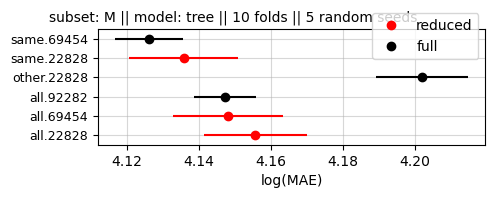

In [10]:
plot_metrics(results_df, 'M', 'tree', 'mae')

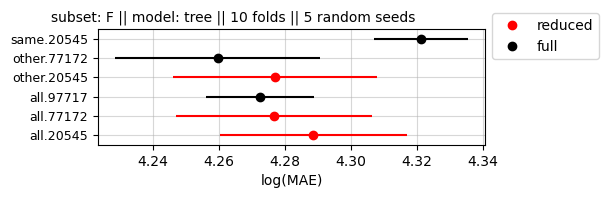

In [11]:
plot_metrics(results_df, 'F', 'tree', 'mae')

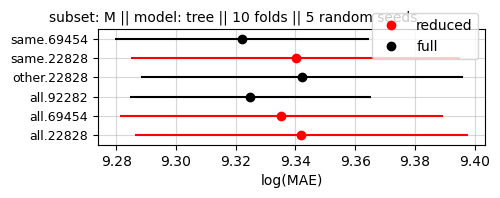

In [12]:
plot_metrics(results_df, 'M', 'tree', 'mse')

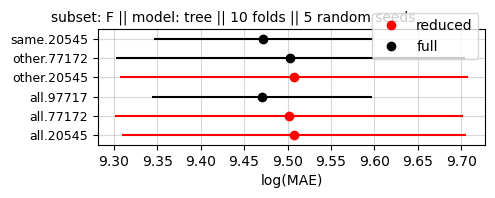

In [13]:
plot_metrics(results_df, 'F', 'tree', 'mse')